<a href="https://colab.research.google.com/github/elegant/forecasting/blob/main/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML models

In [ ]:
!pip install -q downcast
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from downcast import reduce
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [ ]:
api_token = {"username":"", "key":""}

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

import json
with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c m5-forecasting-accuracy
!unzip m5-forecasting-accuracy.zip

In [ ]:
calendar = pd.read_csv("calendar.csv")
# sales_train_validation = pd.read_csv("sales_train_validation.csv")
sell_prices = pd.read_csv("sell_prices.csv")
# sample_submission = pd.read_csv("sample_submission.csv")
sales_train_evaluation = pd.read_csv("sales_train_evaluation.csv")

In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
sales_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


## Feature engg.

### Features- calendar

In [ ]:
#Adding feature 'is_weekend'
f=lambda x: 1 if x<=2 else 0
calendar["is_weekend"]=calendar["wday"].map(f)
calendar["is_weekend"]=calendar["is_weekend"].astype(np.int8)


#Adding feature 'month_day'
m=calendar["date"].tolist()
m=[i.split("-")[2] for i in m]
calendar["month_day"]=m
calendar["month_day"]=calendar["month_day"].astype(np.int8)

#Adding feature 'month_week_number'
calendar["month_week_number"]=(calendar["month_day"]-1) // 7 + 1
calendar["month_week_number"]=calendar["month_week_number"].astype(np.int8)


#Replace 'NaN' values by 'no_event'
cat=["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
for i in cat:
  calendar[i].fillna("no_event",inplace=True)

#Adding feature 'events_per_day'
f=lambda x: 0 if x=="no_event" else 1
calendar["events_per_day"]=calendar["event_type_1"].map(f)
index=calendar.index
indices=index[calendar["event_type_2"]!="no_event"].tolist()
for i in indices:
  calendar["events_per_day"][i]+=1
calendar["events_per_day"]=calendar["events_per_day"].astype(np.int8)

In [ ]:
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_weekend,month_day,month_week_number,events_per_day
0,2011-01-29,11101,Saturday,1,1,2011,d_1,no_event,no_event,no_event,no_event,0,0,0,1,29,5,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,no_event,no_event,no_event,no_event,0,0,0,1,30,5,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,no_event,no_event,no_event,no_event,0,0,0,0,31,5,0


In [ ]:
calendar["date"].nunique()
#No. of days data present is 1969.

1969

### Features- Sales, Sell price

#### Melting, Join

In [ ]:
sales = sales_train_evaluation[sales_train_evaluation["store_id"]=="CA_1"]

In [ ]:
sales = pd.melt(sales, id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], var_name="d", value_name="demand")
sales = pd.merge(sales, calendar, on="d", how="left")
sales = pd.merge(sales, sell_prices, on=["item_id", "store_id", "wm_yr_wk"], how="left")

In [ ]:
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_weekend,month_day,month_week_number,events_per_day,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,no_event,no_event,0,0,0,1,29,5,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,no_event,no_event,0,0,0,1,29,5,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,no_event,no_event,0,0,0,1,29,5,0,NaN


#### Rolling mean

In [ ]:
#mean, median


window=[7, 14, 28, 35, 42]
for i in tqdm(window):
  sales["rolling_mean_"+str(i)]=sales.groupby(["id"])["demand"].transform(lambda s: s.rolling(i,center=False).mean())

#substituting 'NaN' in 'rolling_mean' features with 0
window=["rolling_mean_7", "rolling_mean_14", "rolling_mean_28", "rolling_mean_35", "rolling_mean_42"]
for i in window:
  sales[i]=sales[i].fillna(0)

100%|██████████| 5/5 [00:41<00:00,  8.21s/it]


In [ ]:
sales[sales["item_id"]=="FOODS_1_001"].reset_index().head(50)

,index,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,...,is_weekend,month_day,month_week_number,events_per_day,sell_price,rolling_mean_7,rolling_mean_14,rolling_mean_28,rolling_mean_35,rolling_mean_42
0,1612,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,...,1,29,5,0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,4661,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,2011-01-30,...,1,30,5,0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,7710,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,2011-01-31,...,0,31,5,0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,10759,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,2011-02-01,...,0,1,1,0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,13808,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,2011-02-02,...,0,2,1,0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,16857,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_6,2,2011-02-03,...,0,3,1,0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,19906,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_7,0,2011-02-04,...,0,4,1,0,2.0,1.428571,0.000000,0.000000,0.000000,0.000000
7,22955,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_8,2,2011-02-05,...,1,5,1,0,2.0,1.285714,0.000000,0.000000,0.000000,0.000000
8,26004,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_9,0,2011-02-06,...,1,6,1,1,2.0,1.285714,0.000000,0.000000,0.000000,0.000000
9,29053,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_10,0,2011-02-07,...,0,7,1,0,2.0,1.285714,0.000000,0.000000,0.000000,0.000000


#### Lag

In [ ]:
lags=[28, 35, 42, 49, 56, 63, 70]
for i in tqdm(lags):
  sales["lag_"+str(i)]=sales.groupby(["id"])["demand"].shift(i)

#substituting 'NaN' in 'lags' features with 0
lags=["lag_28", "lag_35", "lag_42", "lag_49", "lag_56", "lag_63", "lag_70"]
for i in lags:
  sales[i]=sales[i].fillna(0)

100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


In [ ]:
sales[sales["item_id"]=="FOODS_1_001"].reset_index().head(50)

,index,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,...,rolling_mean_28,rolling_mean_35,rolling_mean_42,lag_28,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70
0,1612,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4661,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,2011-01-30,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7710,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,2011-01-31,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10759,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,2011-02-01,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13808,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,2011-02-02,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,16857,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_6,2,2011-02-03,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,19906,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_7,0,2011-02-04,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22955,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_8,2,2011-02-05,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,26004,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_9,0,2011-02-06,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,29053,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_10,0,2011-02-07,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Sell price inclusion

In [ ]:
#substituting NaNs with the mean value
sales["sell_price"] = sales["sell_price"].fillna(sales.groupby("id")["sell_price"].transform("mean"))

#### Qualitative vars- Labelencoding

In [ ]:
labelencoder=LabelEncoder()
category=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]
for i in tqdm(category):
  sales[i+"_"] = labelencoder.fit_transform(sales[i])

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


In [ ]:
sales=sales.drop(["id","item_id","dept_id","cat_id","store_id","state_id", "event_name_1","event_type_1","event_name_2","event_type_2"],axis = 1)

In [ ]:
sales.head(3)

,d,demand,date,wm_yr_wk,weekday,wday,month,year,snap_CA,snap_TX,...,id_,item_id_,dept_id_,cat_id_,store_id_,state_id_,event_name_1_,event_type_1_,event_name_2_,event_type_2_
0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0,0,...,1437,1437,3,1,0,0,30,4,4,2
1,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0,0,...,1438,1438,3,1,0,0,30,4,4,2
2,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0,0,...,1439,1439,3,1,0,0,30,4,4,2


#### Feature- Day

In [ ]:
#deleting '_' from 'd' column values
l=[]
for i in sales["d"]:
  l.append(i.split("_")[1])
sales["day"]=l
sales["day"]=sales["day"].astype(np.int16)

In [ ]:
sales.head(3)

,d,demand,date,wm_yr_wk,weekday,wday,month,year,snap_CA,snap_TX,...,item_id_,dept_id_,cat_id_,store_id_,state_id_,event_name_1_,event_type_1_,event_name_2_,event_type_2_,day
0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0,0,...,1437,3,1,0,0,30,4,4,2,1
1,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0,0,...,1438,3,1,0,0,30,4,4,2,1
2,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0,0,...,1439,3,1,0,0,30,4,4,2,1


#### Dropping duplicate columns

In [ ]:
sales = sales.drop(["weekday", "d", "date"], axis=1)

In [ ]:
dataset_with_features = sales.copy()

In [ ]:
dataset_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5918109 entries, 0 to 5918108
Data columns (total 36 columns):
 #   Column             Dtype  
---  ------             -----  
 0   demand             int64  
 1   wm_yr_wk           int64  
 2   wday               int64  
 3   month              int64  
 4   year               int64  
 5   snap_CA            int64  
 6   snap_TX            int64  
 7   snap_WI            int64  
 8   is_weekend         int8   
 9   month_day          int8   
 10  month_week_number  int8   
 11  events_per_day     int8   
 12  sell_price         float64
 13  rolling_mean_7     float64
 14  rolling_mean_14    float64
 15  rolling_mean_28    float64
 16  rolling_mean_35    float64
 17  rolling_mean_42    float64
 18  lag_28             float64
 19  lag_35             float64
 20  lag_42             float64
 21  lag_49             float64
 22  lag_56             float64
 23  lag_63             float64
 24  lag_70             float64
 25  id_               

In [ ]:
print(dataset_with_features.shape)
dataset_with_features

(5918109, 36)


,demand,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,is_weekend,month_day,...,item_id_,dept_id_,cat_id_,store_id_,state_id_,event_name_1_,event_type_1_,event_name_2_,event_type_2_,day
0,0,11101,1,1,2011,0,0,0,1,29,...,1437,3,1,0,0,30,4,4,2,1
1,0,11101,1,1,2011,0,0,0,1,29,...,1438,3,1,0,0,30,4,4,2,1
2,0,11101,1,1,2011,0,0,0,1,29,...,1439,3,1,0,0,30,4,4,2,1
3,0,11101,1,1,2011,0,0,0,1,29,...,1440,3,1,0,0,30,4,4,2,1
4,0,11101,1,1,2011,0,0,0,1,29,...,1441,3,1,0,0,30,4,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918104,2,11617,2,5,2016,0,0,0,1,22,...,1432,2,0,0,0,30,4,4,2,1941
5918105,0,11617,2,5,2016,0,0,0,1,22,...,1433,2,0,0,0,30,4,4,2,1941
5918106,1,11617,2,5,2016,0,0,0,1,22,...,1434,2,0,0,0,30,4,4,2,1941
5918107,1,11617,2,5,2016,0,0,0,1,22,...,1435,2,0,0,0,30,4,4,2,1941


In [ ]:
with open("/content/dataset_with_features.pkl", "wb") as f:
  pickle.dump(dataset_with_features, f)

### Dataset for training- 1 store

In [ ]:
with open("/content/dataset_with_features.pkl", "rb") as f:
  df = pickle.load(f)

In [ ]:
df.columns

Index(['demand', 'wm_yr_wk', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'is_weekend', 'month_day', 'month_week_number',
       'events_per_day', 'sell_price', 'rolling_mean_7', 'rolling_mean_14',
       'rolling_mean_28', 'rolling_mean_35', 'rolling_mean_42', 'lag_28',
       'lag_35', 'lag_42', 'lag_49', 'lag_56', 'lag_63', 'lag_70', 'id_',
       'item_id_', 'dept_id_', 'cat_id_', 'store_id_', 'state_id_',
       'event_name_1_', 'event_type_1_', 'event_name_2_', 'event_type_2_',
       'day'],
      dtype='object')

In [ ]:
print(df.shape)
df.head()

(5918109, 36)


,demand,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,is_weekend,month_day,...,item_id_,dept_id_,cat_id_,store_id_,state_id_,event_name_1_,event_type_1_,event_name_2_,event_type_2_,day
0,0,11101,1,1,2011,0,0,0,1,29,...,1437,3,1,0,0,30,4,4,2,1
1,0,11101,1,1,2011,0,0,0,1,29,...,1438,3,1,0,0,30,4,4,2,1
2,0,11101,1,1,2011,0,0,0,1,29,...,1439,3,1,0,0,30,4,4,2,1
3,0,11101,1,1,2011,0,0,0,1,29,...,1440,3,1,0,0,30,4,4,2,1
4,0,11101,1,1,2011,0,0,0,1,29,...,1441,3,1,0,0,30,4,4,2,1


In [ ]:
df["day"].value_counts()

day
1       3049
1276    3049
1304    3049
1303    3049
1302    3049
        ... 
643     3049
642     3049
641     3049
640     3049
1941    3049
Name: count, Length: 1941, dtype: int64

In [ ]:
df["day"].max()

1941

In [ ]:
df[["id_", "item_id_", "dept_id_", "cat_id_", "store_id_", "state_id_"]].nunique()

id_          3049
item_id_     3049
dept_id_        7
cat_id_         3
store_id_       1
state_id_       1
dtype: int64

In [ ]:
x_train = df.loc[df["day"]<=1885]
x_valid = df.loc[df["day"].isin(list(range(1886, 1914)))]
x_test = df.loc[df["day"]>= 1914]

y_train = x_train["demand"]
y_valid = x_valid["demand"]
y_test = x_test["demand"]

x_train = x_train.drop(["demand"], axis = 1)
x_valid = x_valid.drop(["demand"], axis = 1)
x_test = x_test.drop(["demand"], axis = 1)

print("x_train {}".format(x_train.shape),"  y_train {}".format(y_train.shape))
print("\nx_valid {}".format(x_valid.shape),"  y_valid {}".format(y_valid.shape))
print("\nx_test {}".format(x_test.shape),"  y_test {}".format(y_test.shape))

x_train (5747365, 35)   y_train (5747365,)

x_valid (85372, 35)   y_valid (85372,)

x_test (85372, 35)   y_test (85372,)


In [ ]:
x_test.index

Index([5832737, 5832738, 5832739, 5832740, 5832741, 5832742, 5832743, 5832744,
       5832745, 5832746,
       ...
       5918099, 5918100, 5918101, 5918102, 5918103, 5918104, 5918105, 5918106,
       5918107, 5918108],
      dtype='int64', length=85372)

### Dataset for inference- 1 store

In [ ]:
#for use later
sales2 = sales_train_evaluation[sales_train_evaluation["store_id"]=="CA_1"]
sales2

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823_CA_1_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,3,0,3,1,0,2,4,3,4,2
3045,FOODS_3_824_CA_1_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,1,0,5,0,...,0,0,0,1,2,0,3,0,0,0
3046,FOODS_3_825_CA_1_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,0,2,0,2,0,3,0,1
3047,FOODS_3_826_CA_1_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,1,2,1,3,3,0,1,2,1


## Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
import random

In [ ]:
def rmse(pred,value):
  return np.sqrt(((pred-value)**2).mean())

### 1. Multiple linear regression

In [ ]:
lr = LinearRegression(n_jobs=-1)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_valid)
print("Rmse: {}".format(rmse(y_pred, y_valid)))

Rmse: 1.9072402772105916


In [ ]:
with open("/content/Linear_Regression_model.pkl", "wb") as f:
  pickle.dump(lr, f)

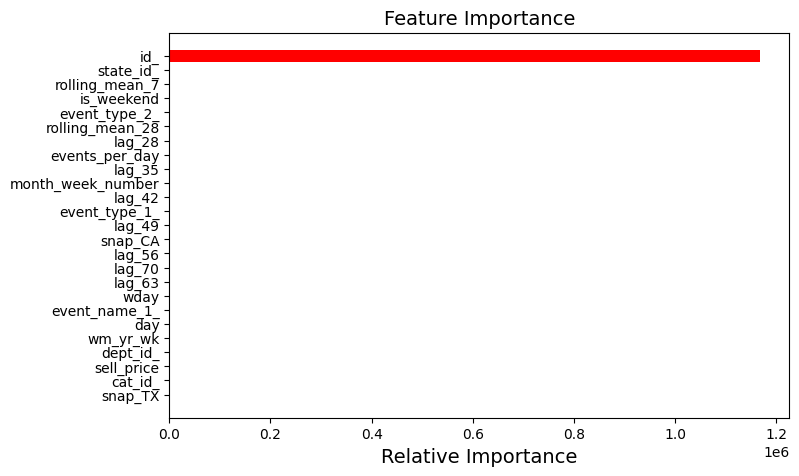

In [ ]:
features=x_train.columns
imp=lr.coef_
indices=(np.argsort(imp))[10:]
plt.figure(figsize=(8, 5))
plt.title("Feature Importance",fontsize=14)
plt.barh(range(len(indices)),imp[indices],color="r")
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel("Relative Importance",fontsize=14)
plt.show()

In [ ]:
x_test

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,is_weekend,month_day,month_week_number,...,item_id_,dept_id_,cat_id_,store_id_,state_id_,event_name_1_,event_type_1_,event_name_2_,event_type_2_,day
5832737,11613,3,4,2016,0,0,0,0,25,4,...,1437,3,1,0,0,30,4,4,2,1914
5832738,11613,3,4,2016,0,0,0,0,25,4,...,1438,3,1,0,0,30,4,4,2,1914
5832739,11613,3,4,2016,0,0,0,0,25,4,...,1439,3,1,0,0,30,4,4,2,1914
5832740,11613,3,4,2016,0,0,0,0,25,4,...,1440,3,1,0,0,30,4,4,2,1914
5832741,11613,3,4,2016,0,0,0,0,25,4,...,1441,3,1,0,0,30,4,4,2,1914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918104,11617,2,5,2016,0,0,0,1,22,4,...,1432,2,0,0,0,30,4,4,2,1941
5918105,11617,2,5,2016,0,0,0,1,22,4,...,1433,2,0,0,0,30,4,4,2,1941
5918106,11617,2,5,2016,0,0,0,1,22,4,...,1434,2,0,0,0,30,4,4,2,1941
5918107,11617,2,5,2016,0,0,0,1,22,4,...,1435,2,0,0,0,30,4,4,2,1941


In [ ]:
sales2

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823_CA_1_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,3,0,3,1,0,2,4,3,4,2
3045,FOODS_3_824_CA_1_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,1,0,5,0,...,0,0,0,1,2,0,3,0,0,0
3046,FOODS_3_825_CA_1_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,0,2,0,2,0,3,0,1
3047,FOODS_3_826_CA_1_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,1,2,1,3,3,0,1,2,1


In [ ]:
s1 = pd.DataFrame()
s2 = pd.DataFrame()

s1["id"]=sales2["id"]

j=1
for i in range(1914, 1942):
  s1["F"+str(j)]=lr.predict(x_test[x_test["day"]==i])
  j+=1

s1["id"]=s1["id"].apply(lambda x: x.replace("evaluation", "validation"))


x_test_evaluation = x_test.copy() #1914-1941
x_test_evaluation["day"] = x_test_evaluation["day"]+28 #1942-1969
s2["id"]=sales2["id"]
j=1
for i in range(1942, 1970):
  s2["F"+str(j)]=lr.predict(x_test_evaluation[x_test_evaluation["day"]==i])
  j+=1


submit_Linear_Regression_=pd.concat([s1, s2]).reset_index().drop(["index"],axis=1)

In [ ]:
submit_Linear_Regression_

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.757951,0.623286,0.470165,0.192947,0.560155,1.009550,1.810628,1.351234,1.637685,...,1.257880,1.940965,1.817938,0.982386,0.911388,0.703764,1.397193,1.204849,1.091257,1.215693
1,HOBBIES_1_002_CA_1_validation,0.093914,0.129625,-0.059585,0.092347,0.066333,0.407467,0.454553,0.123914,-0.157246,...,-0.084194,0.383725,0.721122,0.543125,0.619922,0.705415,0.661578,0.629381,0.814390,0.530727
2,HOBBIES_1_003_CA_1_validation,0.483551,0.355402,0.301981,0.433383,0.515111,1.073542,1.044576,0.568750,0.587428,...,0.815622,1.024377,0.860507,0.367232,0.375832,0.224275,0.550573,0.922462,1.170952,1.156741
3,HOBBIES_1_004_CA_1_validation,1.739905,1.121780,1.466422,1.981019,2.067226,1.713032,2.669809,2.415482,2.236370,...,1.514006,1.905577,1.885462,1.390061,0.728800,0.810193,0.986652,1.170723,2.165055,3.060110
4,HOBBIES_1_005_CA_1_validation,1.894659,1.674736,1.947606,1.867546,1.654203,1.649685,1.851795,1.397021,1.869468,...,1.656281,1.639016,1.402021,0.969281,0.767577,0.553927,0.302594,0.612881,1.022738,1.369297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,FOODS_3_823_CA_1_evaluation,1.042133,1.171080,1.078767,1.207361,0.880563,1.487210,1.491101,1.556843,1.497286,...,1.580464,1.448167,1.929019,1.675990,1.347370,1.704559,1.627477,2.080869,2.385747,2.407545
6094,FOODS_3_824_CA_1_evaluation,0.925231,0.771829,1.279631,0.866299,0.700326,1.099421,1.166092,1.262271,1.342048,...,1.212861,1.144134,1.199810,0.403445,0.308009,0.635685,0.804996,0.886286,1.043320,1.006572
6095,FOODS_3_825_CA_1_evaluation,1.604235,1.148952,1.208605,1.188406,1.263825,1.365702,1.825491,1.054377,1.474164,...,1.195131,1.768673,1.149148,0.764289,0.736451,0.616368,0.329779,0.826776,1.610796,1.586828
6096,FOODS_3_826_CA_1_evaluation,0.962011,0.901888,0.735596,0.580397,0.921206,0.620578,0.566904,0.307108,0.998609,...,1.057732,1.218475,1.783594,1.223567,1.309959,1.295219,1.386109,2.015064,2.119482,2.023888


In [ ]:
submit_Linear_Regression_.to_csv("/content/submit_Linear_Regression_.csv",index=False)

### 2. Decision tree

In [ ]:
#Hyperparamtuning
for i in tqdm(range(5)):
  max_depth=random.randint(1,200)
  min_samples_split=random.randint(10,600)
  min_samples_leaf=random.randint(20,500)
  dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)

  dt.fit(x_train, y_train)
  y_pred=dt.predict(x_valid)

  print("\n\nmax_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse(y_pred,y_valid)))
  print("-"*150)

 20%|██        | 1/5 [01:17<05:09, 77.46s/it]



max_depth: 92   min_samples_split: 132   min_samples_leaf: 346   Rmse: 1.917997385520235
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████      | 2/5 [02:30<03:44, 74.97s/it]



max_depth: 124   min_samples_split: 183   min_samples_leaf: 106   Rmse: 1.847014144694138
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|██████    | 3/5 [03:44<02:28, 74.43s/it]



max_depth: 14   min_samples_split: 557   min_samples_leaf: 131   Rmse: 1.8463283774659558
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 4/5 [05:10<01:18, 78.85s/it]



max_depth: 156   min_samples_split: 315   min_samples_leaf: 398   Rmse: 1.9914784983771916
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 5/5 [06:18<00:00, 75.62s/it]



max_depth: 89   min_samples_split: 13   min_samples_leaf: 243   Rmse: 1.8563630022773818
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
max_depth=14
min_samples_split=557
min_samples_leaf=131
dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)
dt.fit(x_train, y_train)
y_pred=dt.predict(x_valid)
print("max_depth: {}".format(max_depth), "  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse(y_pred, y_valid)))

max_depth: 14   min_samples_split: 557   min_samples_leaf: 131   Rmse: 1.8463283774659558


In [ ]:
with open("/content/decision_tree_model.pkl", "wb") as f:
  pickle.dump(dt, f)

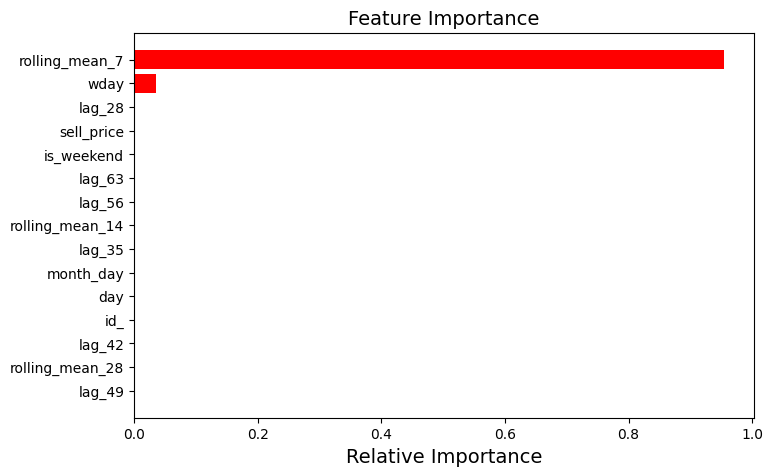

In [ ]:
features=x_train.columns
imp=dt.feature_importances_
indices=(np.argsort(imp))[20:]
plt.figure(figsize=(8, 5))
plt.title("Feature Importance",fontsize=14)
plt.barh(range(len(indices)),imp[indices],color="r")
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel("Relative Importance",fontsize=14)
plt.show()

In [ ]:
s1 = pd.DataFrame()
s2 = pd.DataFrame()

s1["id"]=sales2["id"]

j=1
for i in range(1914, 1942):
  s1["F"+str(j)]=dt.predict(x_test[x_test["day"]==i])
  j+=1

s1["id"]=s1["id"].apply(lambda x: x.replace("evaluation", "validation"))


x_test_evaluation = x_test.copy() #1914-1941
x_test_evaluation["day"] = x_test_evaluation["day"]+28 #1942-1969
s2["id"]=sales2["id"]
j=1
for i in range(1942, 1970):
  s2["F"+str(j)]=dt.predict(x_test_evaluation[x_test_evaluation["day"]==i])
  j+=1


submit_DecisionTree_Regressor_=pd.concat([s1,s2]).reset_index().drop(["index"],axis=1)

In [ ]:
submit_DecisionTree_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.012735,0.701189,0.701189,0.453621,0.453621,0.995700,1.960588,1.384213,1.384213,...,1.384213,1.960588,1.960588,1.012735,1.012735,0.701189,1.012735,1.384213,0.995700,1.445367
1,HOBBIES_1_002_CA_1_validation,0.155639,0.302882,0.155639,0.155639,0.155639,0.155639,0.155639,0.155639,0.000000,...,0.000000,0.155639,0.641158,0.453621,0.701189,0.701189,0.701189,0.701189,0.641158,0.302882
2,HOBBIES_1_003_CA_1_validation,0.701189,0.453621,0.453621,0.701189,0.453621,0.995700,0.995700,0.701189,0.701189,...,0.701189,0.995700,0.641158,0.453621,0.453621,0.453621,0.701189,1.012735,1.445367,0.995700
3,HOBBIES_1_004_CA_1_validation,1.782724,1.782724,1.782724,1.782724,2.170200,1.960588,2.525421,2.170200,2.170200,...,1.384213,1.960588,1.445367,1.012735,1.012735,1.012735,1.384213,1.012735,1.960588,3.063078
4,HOBBIES_1_005_CA_1_validation,1.782724,1.384213,1.782724,1.782724,1.782724,1.960588,1.960588,1.384213,1.782724,...,1.782724,1.960588,1.445367,1.012735,1.012735,0.701189,0.453621,0.701189,0.995700,0.995700


In [ ]:
submit_DecisionTree_Regressor_.to_csv("/content/submit_DecisionTree_Regressor_.csv", index=False)

### 3. Random forest

In [ ]:
#Hyperparamtuning

for i in tqdm(range(5)):
  max_depth = np.random.randint(1, 10)
  min_samples_leaf = np.random.randint(2, 8)
  n_estimators = np.random.randint(10, 20) #50, 100
  print("\n\nmax_depth: {}".format(max_depth), " min_samples_leaf: {}".format(min_samples_leaf), " n_estimators: {}".format(n_estimators))
  rf = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, n_jobs=-1)
  rf.fit(x_train, y_train)
  y_pred = rf.predict(x_valid)
  print("\n\nmax_depth: {}".format(max_depth), "  min_samples_leaf: {}".format(min_samples_leaf), "  n_estimators: {}".format(n_estimators), "  Rmse: {}".format(rmse(y_pred, y_valid)))
  print("-"*150)

  0%|          | 0/5 [00:00<?, ?it/s]



max_depth: 3   min_samples_leaf: 6   n_estimators: 13


 20%|██        | 1/5 [04:23<17:35, 263.89s/it]



max_depth: 3   min_samples_leaf: 6   n_estimators: 13   Rmse: 2.064510110337799
------------------------------------------------------------------------------------------------------------------------------------------------------


max_depth: 2   min_samples_leaf: 4   n_estimators: 19


 40%|████      | 2/5 [08:00<11:48, 236.28s/it]



max_depth: 2   min_samples_leaf: 4   n_estimators: 19   Rmse: 2.2730041570034683
------------------------------------------------------------------------------------------------------------------------------------------------------


max_depth: 3   min_samples_leaf: 7   n_estimators: 16


 60%|██████    | 3/5 [13:33<09:20, 280.29s/it]



max_depth: 3   min_samples_leaf: 7   n_estimators: 16   Rmse: 2.067699606099281
------------------------------------------------------------------------------------------------------------------------------------------------------


max_depth: 3   min_samples_leaf: 3   n_estimators: 14


 80%|████████  | 4/5 [17:26<04:21, 261.54s/it]



max_depth: 3   min_samples_leaf: 3   n_estimators: 14   Rmse: 2.06022077599779
------------------------------------------------------------------------------------------------------------------------------------------------------


max_depth: 1   min_samples_leaf: 4   n_estimators: 15


100%|██████████| 5/5 [18:53<00:00, 226.76s/it]



max_depth: 1   min_samples_leaf: 4   n_estimators: 15   Rmse: 2.7834203678462117
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
max_depth=3
min_samples_leaf=3
n_estimators=14
rf=RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,n_estimators=n_estimators,n_jobs=-1)
rf.fit(x_train, y_train)
y_pred=rf.predict(x_valid)
print("max_depth: {}".format(max_depth),"  min_samples_leaf: {}".format(min_samples_leaf),"  n_estimators: {}".format(n_estimators),"  Rmse: {}".format(rmse(y_pred, y_valid)))

max_depth: 3   min_samples_leaf: 3   n_estimators: 14   Rmse: 2.0661899267255257


In [ ]:
with open("/content/RandomForest_model.pkl", "wb") as f:
  pickle.dump(rf, f)

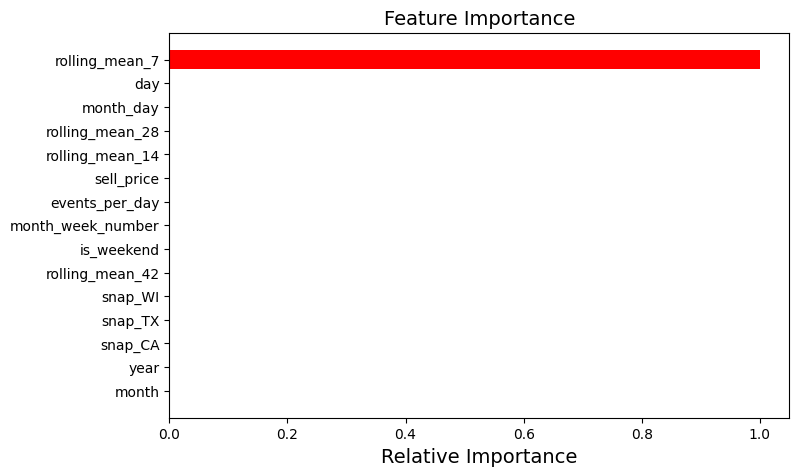

In [ ]:
features=x_train.columns
imp=rf.feature_importances_
indices=(np.argsort(imp))[20:]
plt.figure(figsize=(8, 5))
plt.title("Feature Importance",fontsize=14)
plt.barh(range(len(indices)),imp[indices],color="r")
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel("Relative Importance",fontsize=14)
plt.show()

In [ ]:
s1 = pd.DataFrame()
s2 = pd.DataFrame()

s1["id"]=sales2["id"]

j=1
for i in range(1914, 1942):
  s1["F"+str(j)]=rf.predict(x_test[x_test["day"]==i])
  j+=1

s1["id"]=s1["id"].apply(lambda x: x.replace("evaluation", "validation"))


x_test_evaluation = x_test.copy() #1914-1941
x_test_evaluation["day"] = x_test_evaluation["day"]+28 #1942-1969
s2["id"]=sales2["id"]
j=1
for i in range(1942, 1970):
  s2["F"+str(j)]=rf.predict(x_test_evaluation[x_test_evaluation["day"]==i])
  j+=1


submit_RandomForest_Regressor_=pd.concat([s1,s2]).reset_index().drop(["index"],axis=1)

In [ ]:
submit_RandomForest_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.590668,0.217367,0.217367,0.217367,0.217367,0.217367,1.590668,1.590668,1.590668,...,1.590668,1.590668,1.590668,1.590668,1.590668,0.217367,1.590668,1.590668,0.217367,1.590668
1,HOBBIES_1_002_CA_1_validation,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,...,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367
2,HOBBIES_1_003_CA_1_validation,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,...,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,0.217367,1.590668,1.590668,0.217367
3,HOBBIES_1_004_CA_1_validation,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,...,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668
4,HOBBIES_1_005_CA_1_validation,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,1.590668,...,1.590668,1.590668,1.590668,1.590668,1.590668,0.217367,0.217367,0.217367,0.217367,0.217367


In [ ]:
submit_RandomForest_Regressor_.to_csv("/content/submit_RandomForest_Regressor_.csv", index=False)

### 4. XGBoost

In [ ]:
#Hyperaparamtuning

for i in tqdm(range(5)):
  learning_rate = np.round(np.random.uniform(0.001, 0.05),  4)
  max_leaves = np.random.randint(20, 150)
  min_child_weight = random.randint(20, 100)
  print("\n\nlearning_rate: {}".format(learning_rate), " max_leaves: {}".format(max_leaves), " min_child_weight: {}".format(min_child_weight))
  xgb = XGBRegressor(learning_rate=learning_rate, max_leaves=max_leaves, min_child_weight=min_child_weight, subsample=0.7, colsample_bytree=0.7, grow_policy="lossguide", n_estimators=100, objective="reg:squarederror", booster="gbtree", n_jobs=-1)
  xgb.fit(x_train, y_train)
  y_pred = xgb.predict(x_valid)
  print("\n\nlearning_rate: {}".format(learning_rate), " max_leaves: {}".format(max_leaves), " min_child_weight: {}".format(min_child_weight), "  Rmse: {}".format(rmse(y_pred, y_valid)))
  print("-"*150)

  0%|          | 0/5 [00:00<?, ?it/s]



learning_rate: 0.0067  max_leaves: 113  min_child_weight: 37


 20%|██        | 1/5 [01:57<07:50, 117.54s/it]



learning_rate: 0.0067  max_leaves: 113  min_child_weight: 37   Rmse: 2.3860186018432135
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0107  max_leaves: 97  min_child_weight: 31


 40%|████      | 2/5 [03:57<05:56, 118.95s/it]



learning_rate: 0.0107  max_leaves: 97  min_child_weight: 31   Rmse: 2.105543869491661
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0417  max_leaves: 149  min_child_weight: 35


 60%|██████    | 3/5 [05:46<03:48, 114.26s/it]



learning_rate: 0.0417  max_leaves: 149  min_child_weight: 35   Rmse: 1.8444587366802518
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0243  max_leaves: 27  min_child_weight: 53


 80%|████████  | 4/5 [07:28<01:49, 109.42s/it]



learning_rate: 0.0243  max_leaves: 27  min_child_weight: 53   Rmse: 1.8796606743352948
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0293  max_leaves: 73  min_child_weight: 27


100%|██████████| 5/5 [09:20<00:00, 112.17s/it]



learning_rate: 0.0293  max_leaves: 73  min_child_weight: 27   Rmse: 1.8567309150588145
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
learning_rate=0.0417
max_leaves=149
min_child_weight=35
xgb=XGBRegressor(learning_rate=learning_rate,max_leaves=max_leaves,min_child_weight=min_child_weight,subsample=0.7,colsample_bytree=0.7,grow_policy='lossguide',n_estimators=100,objective='reg:squarederror',booster='gbtree',n_jobs=-1)
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_valid)
print("learning_rate: {}".format(learning_rate),"  max_leaves: {}".format(max_leaves),"  min_child_weight: {}".format(min_child_weight),"  Rmse: {}".format(rmse(y_pred, y_valid)))

learning_rate: 0.0417   max_leaves: 149   min_child_weight: 35   Rmse: 1.8444587366802518


In [ ]:
with open("/content/XGBoost_model.pkl", "wb") as f:
  pickle.dump(xgb, f)

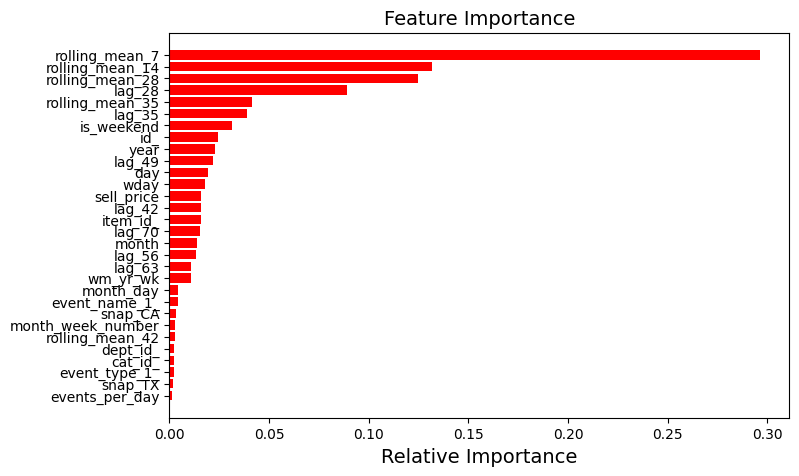

In [ ]:
features=x_train.columns
imp=xgb.feature_importances_
indices=(np.argsort(imp))[5:]
plt.figure(figsize=(8, 5))
plt.title("Feature Importance",fontsize=14)
plt.barh(range(len(indices)),imp[indices],color="r")
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel("Relative Importance",fontsize=14)
plt.show()

In [ ]:
s1 = pd.DataFrame()
s2 = pd.DataFrame()

s1["id"]=sales2["id"]

j=1
for i in range(1914, 1942):
  s1["F"+str(j)]=xgb.predict(x_test[x_test["day"]==i])
  j+=1

s1["id"]=s1["id"].apply(lambda x: x.replace("evaluation", "validation"))


x_test_evaluation = x_test.copy() #1914-1941
x_test_evaluation["day"] = x_test_evaluation["day"]+28 #1942-1969
s2["id"]=sales2["id"]
j=1
for i in range(1942, 1970):
  s2["F"+str(j)]=xgb.predict(x_test_evaluation[x_test_evaluation["day"]==i])
  j+=1


submit_XGBoost_Regressor_=pd.concat([s1,s2]).reset_index().drop(["index"],axis=1)

In [ ]:
submit_XGBoost_Regressor_

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.961984,0.775353,0.675707,0.594641,0.608334,1.067056,1.749241,1.409494,1.276113,...,1.369607,2.005575,1.843428,1.226846,0.890185,0.779335,1.094725,1.369607,1.129489,1.292042
1,HOBBIES_1_002_CA_1_validation,0.108956,0.269696,0.149063,0.149063,0.159541,0.167739,0.176594,0.170310,0.083074,...,0.064654,0.175632,0.486319,0.537397,0.631043,0.629291,0.629291,0.651649,0.632436,0.340944
2,HOBBIES_1_003_CA_1_validation,0.726069,0.566294,0.582160,0.656882,0.565404,0.882455,0.908176,0.690536,0.668551,...,0.789335,0.890412,0.753291,0.562549,0.544079,0.443892,0.630748,0.941567,1.183087,1.034598
3,HOBBIES_1_004_CA_1_validation,1.909156,1.601357,1.706033,1.803681,2.102812,1.967237,2.629923,2.558856,2.261546,...,1.587088,2.027118,1.361753,1.283928,1.038256,1.040403,1.274170,1.302762,1.863600,2.601653
4,HOBBIES_1_005_CA_1_validation,1.688551,1.367350,1.509619,1.625330,1.706378,1.913967,1.827190,1.525432,1.796817,...,1.751895,2.028516,1.501536,1.153479,0.933456,0.738986,0.524185,0.810095,1.136948,1.121652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,FOODS_3_823_CA_1_evaluation,1.158667,1.127224,0.999957,1.088547,0.850203,1.609017,1.430584,1.536450,1.419329,...,1.373304,1.698510,1.955667,1.696302,1.295444,1.293664,1.522751,1.717405,2.892592,2.710558
6094,FOODS_3_824_CA_1_evaluation,0.901725,0.728051,1.052346,0.870470,0.697357,1.024242,1.032482,1.126436,1.278477,...,1.340483,1.405593,1.405593,0.649086,0.492065,0.485552,0.774524,0.841301,1.079249,1.079249
6095,FOODS_3_825_CA_1_evaluation,1.366163,1.094678,0.994750,1.096767,1.318952,1.249067,1.429638,1.040778,1.428119,...,1.356580,1.613010,1.084657,0.869663,0.680528,0.699266,0.606479,0.993155,1.265159,1.392515
6096,FOODS_3_826_CA_1_evaluation,0.918329,0.646062,0.646062,0.775353,0.607614,0.518966,0.467168,0.364085,0.770183,...,0.689633,1.014531,1.389702,1.060529,0.978808,1.192622,1.192622,1.441928,1.910380,1.883665


In [ ]:
submit_XGBoost_Regressor_.to_csv("/content/submit_XGBoost_Regressor_.csv",index=False)

### 5. CatBoost

In [ ]:
#Hyperparamtuning

for i in tqdm(range(5)):
  learning_rate = np.round(np.random.uniform(0.001, 0.05), 4)
  depth = np.random.randint(1, 10)
  num_leaves = np.random.randint(20, 200)
  print("\n\nlearning_rate: {}".format(learning_rate), "  depth: {}".format(depth), "  num_leaves: {}".format(num_leaves))
  cb = CatBoostRegressor(learning_rate=learning_rate, depth=depth, num_leaves=num_leaves, iterations=200, grow_policy='Lossguide', logging_level="Silent")
  cb.fit(x_train, y_train)
  y_pred = cb.predict(x_valid)
  print("\n\nlearning_rate: {}".format(learning_rate), "  depth: {}".format(depth), "  num_leaves: {}".format(num_leaves), "  Rmse: {}".format(rmse(y_pred, y_valid)))
  print("-"*150)

  0%|          | 0/5 [00:00<?, ?it/s]



learning_rate: 0.046   depth: 3   num_leaves: 33


 20%|██        | 1/5 [09:32<38:08, 572.09s/it]



learning_rate: 0.046   depth: 3   num_leaves: 33   Rmse: 1.8314284669697667
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0401   depth: 2   num_leaves: 91


 40%|████      | 2/5 [16:10<23:30, 470.04s/it]



learning_rate: 0.0401   depth: 2   num_leaves: 91   Rmse: 1.8679915957194337
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0205   depth: 6   num_leaves: 46


 60%|██████    | 3/5 [33:22<24:13, 726.55s/it]



learning_rate: 0.0205   depth: 6   num_leaves: 46   Rmse: 1.825421422946361
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0387   depth: 1   num_leaves: 79


 80%|████████  | 4/5 [37:18<08:52, 532.97s/it]



learning_rate: 0.0387   depth: 1   num_leaves: 79   Rmse: 1.9632865519338696
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0105   depth: 5   num_leaves: 38


100%|██████████| 5/5 [53:08<00:00, 637.77s/it]



learning_rate: 0.0105   depth: 5   num_leaves: 38   Rmse: 1.871608048311775
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
learning_rate=0.0205
depth=6
num_leaves=46
cb=CatBoostRegressor(learning_rate=learning_rate,depth=depth,num_leaves=num_leaves,iterations=200,grow_policy='Lossguide',logging_level="Silent")
cb.fit(x_train,y_train)
y_pred=cb.predict(x_valid)
print("learning_rate: {}".format(learning_rate),"  depth: {}".format(depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))

learning_rate: 0.0205   depth: 6   num_leaves: 46   Rmse: 1.825421422946361


In [ ]:
with open("/content/CatBoost_model.pkl", "wb") as f:
  pickle.dump(cb,f)

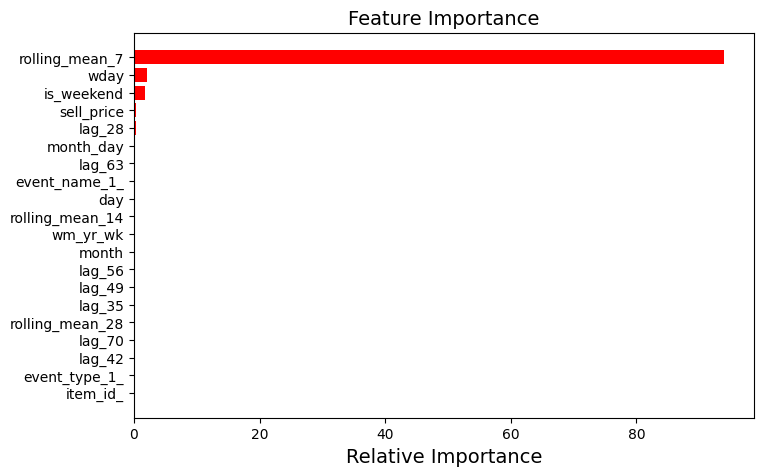

In [ ]:
features=x_train.columns
imp=cb.feature_importances_
indices=(np.argsort(imp))[15:]
plt.figure(figsize=(8, 5))
plt.title("Feature Importance",fontsize=14)
plt.barh(range(len(indices)),imp[indices],color="r")
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel("Relative Importance",fontsize=14)
plt.show()

In [ ]:
s1 = pd.DataFrame()
s2 = pd.DataFrame()

s1["id"]=sales2["id"]

j=1
for i in range(1914, 1942):
  s1["F"+str(j)]=cb.predict(x_test[x_test["day"]==i])
  j+=1

s1["id"]=s1["id"].apply(lambda x: x.replace("evaluation", "validation"))


x_test_evaluation = x_test.copy() #1914-1941
x_test_evaluation["day"] = x_test_evaluation["day"]+28 #1942-1969
s2["id"]=sales2["id"]
j=1
for i in range(1942, 1970):
  s2["F"+str(j)]=cb.predict(x_test_evaluation[x_test_evaluation["day"]==i])
  j+=1


submit_CatBoost_Regressor_=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [ ]:
submit_CatBoost_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.947023,0.737545,0.635477,0.527661,0.557708,1.065068,1.838727,1.468072,1.344876,...,1.363038,2.051629,1.938861,1.219723,0.868011,0.736214,1.099657,1.360030,1.067227,1.277226
1,HOBBIES_1_002_CA_1_validation,0.150195,0.300319,0.147719,0.147719,0.153583,0.182346,0.182383,0.151025,0.040064,...,0.039271,0.182346,0.517283,0.561016,0.650532,0.649326,0.649326,0.697736,0.716424,0.359367
2,HOBBIES_1_003_CA_1_validation,0.680443,0.527661,0.527661,0.635477,0.555010,0.906510,0.911951,0.702004,0.661892,...,0.799961,0.899571,0.712680,0.552234,0.527786,0.418800,0.635477,0.944962,1.276537,1.065240
3,HOBBIES_1_004_CA_1_validation,1.920280,1.524401,1.679933,1.801123,2.169790,1.770376,2.648000,2.649789,2.413354,...,1.589597,1.945960,1.323472,1.262510,0.974677,0.976479,1.250568,1.221775,1.853491,2.843741
4,HOBBIES_1_005_CA_1_validation,1.744141,1.389674,1.542649,1.698088,1.753687,1.925181,1.857036,1.597313,1.887811,...,1.755478,1.932782,1.428723,1.073400,0.868431,0.636751,0.421554,0.687423,1.068906,1.094326


In [ ]:
submit_CatBoost_Regressor_.to_csv("/content/submit_CatBoost_Regressor_.csv", index=False)

### 6. LightGBM

In [ ]:
#Hyperaparamtuning

for i in tqdm(range(5)):
  learning_rate=np.round(np.random.uniform(0.001, 0.05), 4)
  max_depth=np.random.randint(5, 200)
  num_leaves=np.random.randint(20, 300)
  print("\n\nlearning_rate: {}".format(learning_rate), "  max_depth: {}".format(max_depth), "  num_leaves: {}".format(num_leaves))
  lgb=LGBMRegressor(learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_jobs=-1, n_estimators=100)
  lgb.fit(x_train, y_train)
  y_pred=lgb.predict(x_valid)
  print("\n\nlearning_rate: {}".format(learning_rate), "  max_depth: {}".format(max_depth), "  num_leaves: {}".format(num_leaves), "  Rmse: {}".format(rmse(y_pred, y_valid)))
  print("-"*150)

  0%|          | 0/5 [00:00<?, ?it/s]



learning_rate: 0.0014   max_depth: 38   num_leaves: 213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.347035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 5747365, number of used features: 33
[LightGBM] [Info] Start training from score 1.317171


 20%|██        | 1/5 [02:11<08:47, 131.86s/it]



learning_rate: 0.0014   max_depth: 38   num_leaves: 213   Rmse: 3.1543523611306044
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0052   max_depth: 13   num_leaves: 250
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.316785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 5747365, number of used features: 33
[LightGBM] [Info] Start training from score 1.317171


 40%|████      | 2/5 [04:30<06:47, 135.94s/it]



learning_rate: 0.0052   max_depth: 13   num_leaves: 250   Rmse: 2.533657858191216
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0358   max_depth: 91   num_leaves: 57
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.290559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 5747365, number of used features: 33
[LightGBM] [Info] Start training from score 1.317171


 60%|██████    | 3/5 [05:58<03:48, 114.13s/it]



learning_rate: 0.0358   max_depth: 91   num_leaves: 57   Rmse: 1.826466048914634
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0058   max_depth: 65   num_leaves: 59
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.365428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 5747365, number of used features: 33
[LightGBM] [Info] Start training from score 1.317171


 80%|████████  | 4/5 [07:49<01:52, 112.86s/it]



learning_rate: 0.0058   max_depth: 65   num_leaves: 59   Rmse: 2.4737933998113926
------------------------------------------------------------------------------------------------------------------------------------------------------


learning_rate: 0.0257   max_depth: 55   num_leaves: 159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.372952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 5747365, number of used features: 33
[LightGBM] [Info] Start training from score 1.317171


100%|██████████| 5/5 [09:39<00:00, 115.91s/it]



learning_rate: 0.0257   max_depth: 55   num_leaves: 159   Rmse: 1.8361454170948766
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
learning_rate=0.0358
max_depth=91
num_leaves=57
lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
lgb.fit(x_train,y_train)
y_pred=lgb.predict(x_valid)
print("learning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.483801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 5747365, number of used features: 33
[LightGBM] [Info] Start training from score 1.317171
learning_rate: 0.0358   max_depth: 91   num_leaves: 57   Rmse: 1.826466048914634


In [ ]:
with open("/content/lgb_model.pkl", "wb") as f:
  pickle.dump(lgb,f)

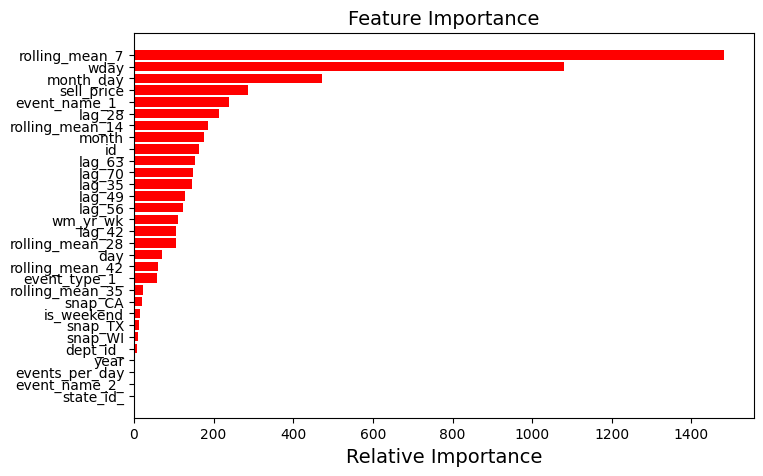

In [ ]:
features=x_train.columns
imp=lgb.feature_importances_
indices=(np.argsort(imp))[5:]
plt.figure(figsize=(8, 5))
plt.title("Feature Importance",fontsize=14)
plt.barh(range(len(indices)),imp[indices],color="r")
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel("Relative Importance",fontsize=14)
plt.show()

In [ ]:
s1 = pd.DataFrame()
s2 = pd.DataFrame()

s1["id"]=sales2["id"]

j=1
for i in range(1914, 1942):
  s1["F"+str(j)]=lgb.predict(x_test[x_test["day"]==i])
  j+=1

s1["id"]=s1["id"].apply(lambda x: x.replace("evaluation", "validation"))


x_test_evaluation = x_test.copy() #1914-1941
x_test_evaluation["day"] = x_test_evaluation["day"]+28 #1942-1969
s2["id"]=sales2["id"]
j=1
for i in range(1942, 1970):
  s2["F"+str(j)]=lgb.predict(x_test_evaluation[x_test_evaluation["day"]==i])
  j+=1


submit_LGBM_Regressor_=pd.concat([s1,s2]).reset_index().drop(["index"],axis=1)

In [ ]:
submit_LGBM_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.946514,0.774048,0.678269,0.549200,0.552219,1.037445,1.781596,1.398862,1.282138,...,1.360089,2.022856,1.934704,1.237437,0.897597,0.774048,1.119193,1.360089,1.033274,1.250703
1,HOBBIES_1_002_CA_1_validation,0.173581,0.310229,0.173581,0.173581,0.176600,0.189011,0.189011,0.173581,0.051840,...,0.051840,0.189011,0.517900,0.556012,0.678269,0.678269,0.678269,0.697677,0.692975,0.355018
2,HOBBIES_1_003_CA_1_validation,0.699836,0.549200,0.549200,0.678269,0.552219,0.852894,0.848510,0.699836,0.678269,...,0.805149,0.848510,0.692975,0.556012,0.549200,0.435376,0.678269,0.936527,1.250703,1.033274
3,HOBBIES_1_004_CA_1_validation,1.928681,1.574318,1.732596,1.841591,2.161319,1.760121,2.554017,2.548593,2.341391,...,1.551226,1.934704,1.266958,1.249746,1.002396,1.002396,1.251805,1.215838,1.786556,2.777787
4,HOBBIES_1_005_CA_1_validation,1.749965,1.425566,1.582243,1.740521,1.720468,1.934704,1.789522,1.551600,1.845729,...,1.720468,1.934704,1.417376,1.062020,0.897597,0.678269,0.435376,0.697677,1.033274,1.041199


In [ ]:
submit_LGBM_Regressor_.to_csv("/content/submit_LGBM_Regressor_.csv",index=False)

### Model comparison

In [ ]:
s = [["1", "Moving Average", 3.2802],
        ["2", "Linear Regression", 1.9072402772105916],
        ["3", "Decision Tree Regressor", 1.8463283774659558],
        ["4", "Random Forest Regressor", 2.0661899267255257],
        ["5", "XGBoost Regressor", 1.8444587366802518],
        ["6", "CatBoost Regressor", 1.825421422946361],
        ["7", "LightGBM Regressor", 1.826466048914634]
      ]
pd.DataFrame(s, columns=["No.", "Model Name", "RMSE"])

,No.,Model Name,RMSE
0,1,Moving Average,3.280200
1,2,Linear Regression,1.907240
2,3,Decision Tree Regressor,1.846328
3,4,Random Forest Regressor,2.066190
4,5,XGBoost Regressor,1.844459
5,6,CatBoost Regressor,1.825421
6,7,LightGBM Regressor,1.826466
